In [1]:
# pip install openpyxl
# pip install conjugate-prior
from conjugate_prior import GammaPoisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gamma, poisson, nbinom, truncnorm
from scipy.special import softmax
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Úloha 1

## Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

### Načtení dat

In [2]:
data_task1a = pd.read_excel('Projekt-2_Data.xlsx')
print(data_task1a)


       uloha_1 a)  uloha_1 b)_prior  skupina  uloha_1 b)_pozorování
0             2.0          3.634785        0               3.626656
1             2.0          2.868113        0               3.008269
2             1.0          2.149160        0               2.989829
3             3.0          4.263065        0               2.371630
4             0.0          2.594745        0               4.009366
...           ...               ...      ...                    ...
99995         NaN          1.725637     9999                    NaN
99996         NaN          4.048414     9999                    NaN
99997         NaN          3.000662     9999                    NaN
99998         NaN          3.058451     9999                    NaN
99999         NaN          4.487418     9999                    NaN

[100000 rows x 4 columns]


Z expertního odhadu víme, že každou 5 ms dojde k 10 připojením. Expertní odhad parametru lambda je tedy roven 2.

Z tabulek (https://en.wikipedia.org/wiki/Conjugate_prior) vidíme, že konjugované apriorní rozdělení je Gamma rozdělení s parametry 'k' a 'lambda'.

### Výpočet pomocí knihovny

Hlavní výpočet je v následující podsekci, zde pouze demonstrace fungování knihovny conjugate_prior.

Assuming first parameter is the Expectancy


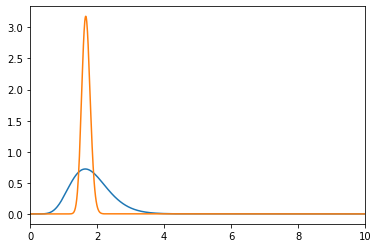

In [3]:
alpha = 10 
beta = 5 
prior_model = GammaPoisson(alpha)
updated_model = prior_model.update(alpha, beta)
updated_model.plot()

posterior = updated_model.update(data_task1a["uloha_1 a)"].dropna())
posterior.plot()

### Manuální výpočet

**Úloha 1-a-1**

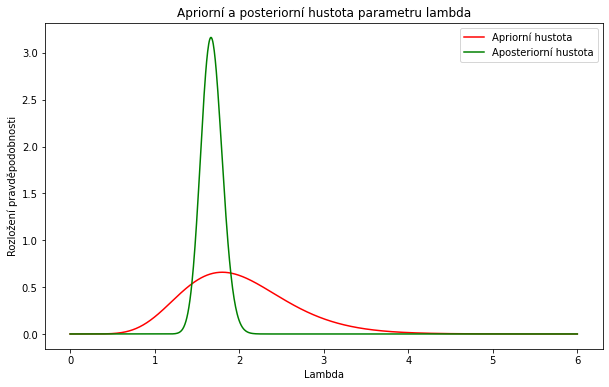

In [4]:
# filtrovana data (bez NaN hodnot)
filtered_data_task1a = data_task1a["uloha_1 a)"].dropna()

# prior parametry
alpha_prior = 10.0
beta_prior = 5.0

# posterior parametry
alpha_posterior = alpha_prior + filtered_data_task1a.sum()
beta_posterior = beta_prior + len(filtered_data_task1a)

# rozsah lambda hodnot
lambdas = np.linspace(0, filtered_data_task1a.max()+1, 1000) # 1000 bodu mezi 0 a max hodnotou+1

# pravdepodobnostni funkce
prior = gamma.pdf(lambdas, alpha_prior, scale=1/beta_prior)
posterior = gamma.pdf(lambdas, alpha_posterior, scale=1/beta_posterior)

# vykresleni
plt.figure(figsize=(10, 6))
plt.plot(lambdas, prior, label='Apriorní hustota', color='red')
plt.plot(lambdas, posterior, label='Aposteriorní hustota', color='green')
plt.legend()
plt.title('Apriorní a posteriorní hustota parametru lambda')
plt.xlabel('Lambda')
plt.ylabel('Rozložení pravděpodobnosti')
plt.show()

**Úloha 1-a-2**

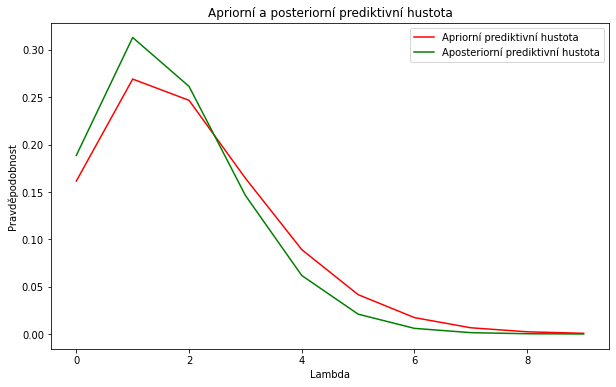

In [5]:
# vyuzijeme parametru z predchoziho kroku pro vypocet parametru prediktivni hustoty (prior i posterior)
# vyuzijeme binomialniho rozdeleni (prepis vzorce)
# prior parametry
binomial_alpha_prior = alpha_prior
binomial_beta_prior = beta_prior / (beta_prior + 1)

# posterior parametry
binomial_alpha_posterior = alpha_posterior
binomial_beta_posterior = beta_posterior / (beta_posterior + 1)

x_values = np.arange(0, filtered_data_task1a.max()+5) # experimentalne nastaveno na 5, aby byl videt "ocas"

predictive_probs_prior = nbinom.pmf(x_values, binomial_alpha_prior, binomial_beta_prior)
predictive_probs_posterior = nbinom.pmf(x_values, binomial_alpha_posterior, binomial_beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(x_values, predictive_probs_prior, label='Apriorní prediktivní hustota', color='red')
plt.plot(x_values, predictive_probs_posterior, label='Aposteriorní prediktivní hustota', color='green')
plt.title('Apriorní a posteriorní prediktivní hustota')
plt.xlabel('Lambda')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

**Úloha 1-a-3**

In [6]:
# interval spolehlivosti pro parametr lambda z apriorního a aposteriorního rozdělení
lambda_prior_low = gamma.ppf(0.025, a=alpha_prior, scale=1/beta_prior)
lambda_prior_high = gamma.ppf(0.975, a=alpha_prior, scale=1/beta_prior)

lambda_posterior_low = gamma.ppf(0.025, a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_high = gamma.ppf(0.975, a=alpha_posterior, scale=1/beta_posterior)

print(f"95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <{round(lambda_prior_low, 5)}, {round(lambda_prior_high, 5)}>")
print(f"95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <{round(lambda_posterior_low, 5)}, {round(lambda_posterior_high, 5)}>")

95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <0.95908, 3.41696>
95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <1.43769, 1.93272>


**Porovnání**: 

Z intervalů vidíme, že z apriorního rozdělení získáváme mnohem širší interval možných hodnot, kdežto v případě aposteriorního je interval se stejnou spolehlivostí značně užší. 
Obecně platí, že apriorní rozložení je založeno na nějaké expertní informaci, aniž bychom pozorovali data. Aposteriorní rozložení pak bere v potaz jak expertní informaci, tak skutečně naměřená data. U výsledků tedy dává smysl, že před zahrnutím skutečně naměřených hodnot je interval širší (více možných hodnot parametru), až po započítání skutečných hodnot získáváme užší, přesnější interval. 

**Úloha 1-a-4**

In [7]:
# bodove odhady parametru lambda
mean_estimate = alpha_posterior/beta_posterior                              # prumer
median_estimate = gamma.median(a=alpha_posterior, scale=1/beta_posterior)   # stredni hodnota (stred intervalu)

print(f"Bodový odhad parametru lambda za použití střední hodnoty: {mean_estimate:.5f}")
print(f"Bodový odhad parametru lambda za použití mediánu: {median_estimate:.5f}")

Bodový odhad parametru lambda za použití střední hodnoty: 1.67619
Bodový odhad parametru lambda za použití mediánu: 1.67302


**Komentář k výběru a porovnání:**

Jako bodové odhady lze zvolit průměr, medián, příp. modus. Platí-li, že jsou data nevychýlená, tyto 3 hodnoty by se měly rovnat. 
Obecně platí, že průměr je citlivý na extrémní hodnoty. Výhodou je, že zahrnuje všechny hodnoty, což se nám hodí v případě, kdy máme důvěru v rozumné modelování a nemáme silné důvody některým hodnotám nevěřit.
Medián odpovídá střední hodnotě intervalu a na rozdíl od průměru je odolnější vůči extrémním hodnotám a ukazuje hodnotu, pod kterou a nad kterou leží stejné procento dat (tj. jedná se o 50. percentil). V případě výraznějších odchylek od normálního rozdělení může medián sloužit jako lepší ukazatel střední hodnoty než průměr. 
V našem případě však vidíme, že hodnoty obou bodových odhadů jsou velmi podobné, a tedy lze předpokládat, že data nijak vychýlená nebudou.


**Úloha 1-a-5**

In [9]:
# bodovy odhad prumeru a medianu z apriorniho pravdepodobnostniho rozdeleni (binomicka distribuce)
# prumer z binomickeho rozdeleni = (r(1-p))/p (https://en.wikipedia.org/wiki/Negative_binomial_distribution)
def mean_binomial(r, p):
    return (r*(1.0-p))/p

# apriorni prumer
mean_estimate_prior = mean_binomial(binomial_alpha_prior, binomial_beta_prior)

# apriorni median
# median_estimate_prior = nbinom.median(binomial_alpha_prior, binomial_beta_prior)

# bodovy odhad prumeru a medianu z aposteriorniho pravdepodobnostniho rozdeleni (binomicka distribuce)
# aposteriorni prumer
mean_estimate_posterior = mean_binomial(binomial_alpha_posterior, binomial_beta_posterior)

# aposteriorni median
# median_estimate_posterior = nbinom.median(binomial_alpha_posterior, binomial_beta_posterior)

print(f"Bodový odhad parametru lambda za použití průměru z apriorního pravděpodobnostního rozdělení: {mean_estimate_prior:.5f}")
print(f"Bodový odhad parametru lambda za použití průměru z aposteriorního pravděpodobnostního rozdělení: {mean_estimate_posterior:.5f}\n")
# print(f"Bodový odhad parametru lambda za použití mediánu z apriorního pravděpodobnostního rozdělení: {median_estimate_prior:.5f}")
# print(f"Bodový odhad parametru lambda za použití mediánu z aposteriorního pravděpodobnostního rozdělení: {median_estimate_posterior:.5f}")


Bodový odhad parametru lambda za použití průměru z apriorního pravděpodobnostního rozdělení: 2.00000
Bodový odhad parametru lambda za použití průměru z aposteriorního pravděpodobnostního rozdělení: 1.67619



**Porovnání:**

Bodový odhad lambda za použití průměru vyšel 2, což by nemělo být překvapením, neboť ze zadání víme, že za 5 ms dojde k 10 připojením, tj. za 1 ms dojde ke 2 připojením (náš výsledek). Tento odhad však nezahrnuje skutečná data, se kterými získáváme výsledek 1,67. Z toho můžeme odvodit, že v naměřených datech došlo za 1 ms průměrně k menšímu počtu připojení než 2. Pro ilustraci v grafu níže vidíme celkové zastoupení jednotlivých hodnot parametru lambda. *Zakomentovaný kód by pak ukazoval výsledky mediánu, zadání však vyžadovalo pouze jeden bodový odhad z apriorního a aposteriorního rozdělení.*

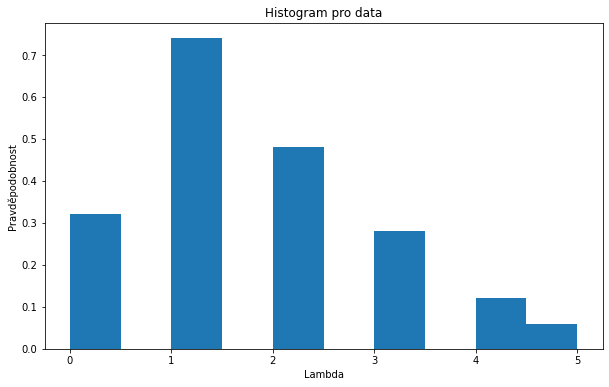

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_data_task1a, density=True)
plt.title('Histogram pro data')
plt.xlabel('Lambda')
plt.ylabel('Pravděpodobnost')
plt.show()

## Aproximace diskrétním rozdělením

**Úloha 1-b-1**

Tu sme mali viacero problémov. Prvý bol s tvorbou apriórneho rozdelenia pre parameter
"b". Postup, ktorí väčšina z nás zvolila bol nasledujúci:
V každej skupine (z 10 000 skupín, kde každá mala 10 nameraných hodnôt) sme našli
najväčšiu hodnotu. Týchto 10 000 hodnôt sme dali do jednej dátovej sady a vytvorili sme z
nich diskrétne rozdelenie. Toto diskrétne rozdelenie bolo urobené rozdelením všetkých 10
000 hodnôt na intervaly. (Napríklad celý interval hodnôt rozdelíme na 50 intervalov o
rovnakej šírke). Takto bolo získané (žlté) diskrétne apriórne rozdelenie uložené v obrázku
"output.png" v prílohe tohto mailu. Každému intervalu vieme dať "predstaviteľa", t.j.
napríklad stred daného intervalu. Týmto získame diskrétne rozdelenie, ktoré má 50 možných
vstupov, t.j. 50 rôznych parametrov "b" (stredy intervalov) s rôznymi pravdepodobnosťami.

In [24]:
# nacteni dat
data_task1b = pd.read_excel('Projekt-2_Data.xlsx')
data_task1b_observations = data_task1b["uloha_1 b)_pozorování"].dropna()

# nalezneme maxima pro každou skupinu
data_task1b = data_task1b.iloc[:, [1,2]] # skupina a uloha_1 b)_pozorovani
data_task1b_max_value = pd.DataFrame({k: [max(v)] for k, v in data_task1b.groupby("skupina")["uloha_1 b)_prior"]})


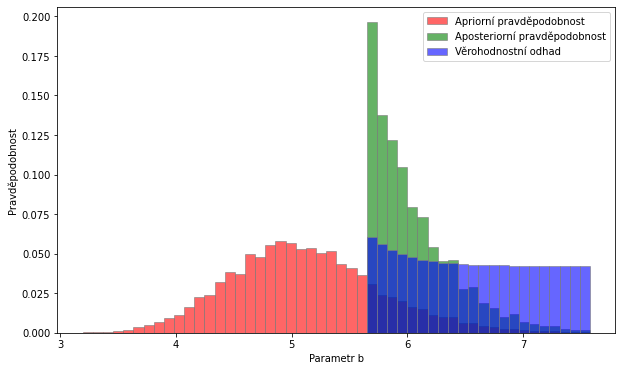

In [32]:
# provedeme binning dat (rozdeleni do skupin)
# aktualne mame 100 000/10 = 10 000 hodnot, ktere rozdelime do 50 kosu (binu)
# maximalni hodnoty rozradime do binu o stejne sirce, navratova hodnota je: pocet hodnot v binu, hranice binu (prava)
num_of_values_in_bin, bins_edges = np.histogram(data_task1b_max_value, bins=50) 
prior_prob = num_of_values_in_bin/num_of_values_in_bin.sum() # normalizace, abychom ziskali pravdepodobnosti (apriorni)

# vypocteme "reprezentanta" z kazdeho intervalu (stred intervalu)
# takto ziskame diskretni rozdeleni, ktere ma 50 moznych vstupu (50 ruznych parametru b s ruznymi pravdepodobnostmi)
bins_centers = bins_edges[:-1] + np.diff(bins_edges)/2

likelihood_estimate = []

# vime, ze delka zpracovani procesu v milisekundach ms ma odseknute normalni rozdeleni (truncated normal distribution)
    # tzn. rozdeleni je normalni, ale jen v urcitem rozsahu
# pro kazdy parametr b (vsech 50) ziskame pravdepodobnost (v log domene), ktera nam rika, jak je pravdepodobne, ze hodnota b je spravna
# tuto pravdepodobnostni funkci nasledne pouzijeme pro vypocet aposteriorni pravdepodobnosti
mu = 3
sigma = 1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
for bin in bins_centers:
    likelihood_estimate.append(np.sum(truncnorm(a=(1-mu)/sigma, b=(bin-mu)/sigma, loc=mu, scale=sigma).logpdf(data_task1b_observations)))

# hodnoty likelihood jsou v log domene, potrebujeme rozsah <0,1>, vyuzijeme soft-max funkci, ktera ma vystup v pozadovanem rozsahu <0,1>
likelihood_probs = softmax(likelihood_estimate)

# "tabulkova metodu" pri diskretni promenne pro vypocet posterior pravdepodobnosti jako na cviceni
posterior_estimate = prior_prob*likelihood_probs                # apriorni pravdepodobnost * verohodnostní odhad (vaha)
posterior_probs = posterior_estimate/posterior_estimate.sum()   # normalizace (abychom dostali pravdepodobnosti, tj. rozsah <0,1>)

plt.figure(figsize=(10, 6))
plt.hist(bins_edges[:-1], bins_edges, weights=prior_prob, label='Apriorní pravděpodobnost', alpha=0.6, color='red', edgecolor='grey')
plt.hist(bins_edges[:-1], bins_edges, weights=posterior_probs, label='Aposteriorní pravděpodobnost', alpha=0.6, color='green', edgecolor='grey')
plt.hist(bins_edges[:-1], bins_edges, weights=likelihood_probs, label='Věrohodnostní odhad', alpha=0.6, color='blue', edgecolor='grey')
plt.xlabel('Parametr b')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

**Úloha 1-b-2**

In [48]:
# stred binu + odpovidajici aposteriorni pravdepodobnost, zip fce tyto 2 hodnoty spoji do jednoho objektu
# sorted fce sestupne seradi objekty podle druhe hodnoty (pravdepodobnosti) od nejvetsi po nejmensi
sorted_posterior = sorted(zip(bins_centers, posterior_probs), key=lambda x: x[1], reverse=True)

# spocte kumulativni (serazene) aposteriorni pravdepodobnosti (kumulativni suma pole), dostavame tedy distribucni funkci aposteriorni pravdepodobnosti
cumulative_probs = np.cumsum([prob for _, prob in sorted_posterior])

# pomoci distribucni fce nalezneme rozmezi 95% intervalu spolehlivosti (argmax vraci index prvniho prvku, ktery je vetsi nez hledana hodnota)
lower_bound_index = np.argmax(cumulative_probs >= 0.025)
upper_bound_index = np.argmax(cumulative_probs >= 0.975)

# indexy poslouzi k pristupu k hodnote parametru b
lower_bound = sorted_posterior[lower_bound_index][0]
upper_bound = sorted_posterior[upper_bound_index][0]

print(f"95% interval spolehlivosti pro parametr b z aposteriorní hustoty: <{lower_bound:.5f}, {upper_bound:.5f}>")

95% interval spolehlivosti pro parametr b z aposteriorní hustoty: <5.69371, 7.00891>


**Úloha 1-b-3**

In [56]:
# bodove odhady parametru b
mean_estimate = np.sum(bins_centers * posterior_probs)      # vahovany prumer (kazdy parametr b ma prirazenou pravdepodobnost)
mode_estimate = bins_centers[np.argmax(posterior_probs)]    # parametr b s nejvetsi pravdepodobnosti

print(f"Bodový odhad parametru b za použití průměru z aposteriorního rozdělení: {mean_estimate:.5f}")
print(f"Bodový odhad parametru b za použití modu z aposteriorního rozdělení: {mode_estimate:.5f}")

Bodový odhad parametru b za použití průměru z aposteriorního rozdělení: 6.05277
Bodový odhad parametru b za použití modu z aposteriorního rozdělení: 5.69371


# Úloha 2

### Čištění dat

In [ ]:
data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name=1)
print(data)

      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717         47
1        iOS         7549          0.3461        0.6539         46
2    Windows         8855          0.2178        0.7822         55
3    Android         8870          0.0794        0.9206         56
4      MacOS         9559          0.7282        0.2718         76
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026         28
498    MacOS         1392          0.2373        0.7627         24
499      iOS         6014          0.8112        0.1888         54
500  Android         5118          0.2345        0.7655         39
501    MacOS         2660          0.9390        0.0610         55

[502 rows x 5 columns]


Vidíme, že atributy InteractingPct a ScrollingPct jsou na sobě zřejmě závislé, neboť lze spočítat jeden z druhého a naopak (např. 1-InteractingPct=ScrollingPct). Můžeme si tedy bez újmy na kvalitě dovolit vyřadit 1 z těchto parametrů.

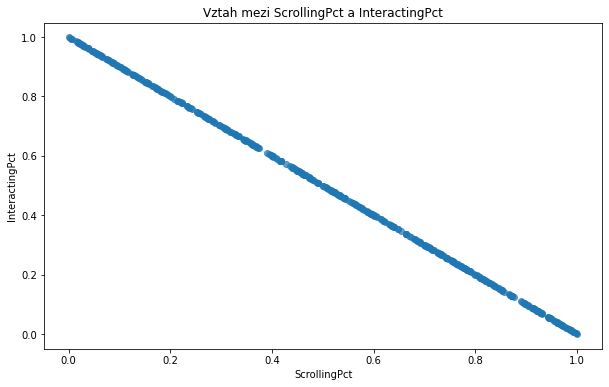

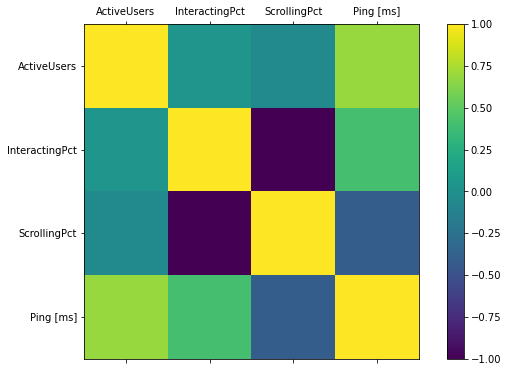

      OSType  ActiveUsers  InteractingPct  Ping
0        iOS         4113          0.8283    47
1        iOS         7549          0.3461    46
2    Windows         8855          0.2178    55
3    Android         8870          0.0794    56
4      MacOS         9559          0.7282    76
..       ...          ...             ...   ...
497      iOS         5315          0.1974    28
498    MacOS         1392          0.2373    24
499      iOS         6014          0.8112    54
500  Android         5118          0.2345    39
501    MacOS         2660          0.9390    55

[502 rows x 4 columns]


In [ ]:
# plot relationship between ScrollingPct   and InteractingPct
plt.figure(figsize=(10, 6))
plt.scatter(data['ScrollingPct'], data['InteractingPct'], alpha=0.7)
plt.title('Vztah mezi ScrollingPct a InteractingPct')
plt.xlabel('ScrollingPct')
plt.ylabel('InteractingPct')
plt.show()

# plot correlation matrix of numeric variables
# first select only numeric variables
numeric_variables = data.select_dtypes(include=[np.number])
# then plot the correlation matrix
plt.figure(figsize=(10, 6))
plt.matshow(numeric_variables.corr(), fignum=1)
plt.xticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.yticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.colorbar()
plt.show()

# drop ScrollingPct column
data = data.drop('ScrollingPct', axis=1)
data = data.rename(columns={'Ping [ms]': 'Ping'})
print(data)

### Splnění předpokladů lineární regrese a základní regresní diagnostiky

### Analýza odlehlých hodnot

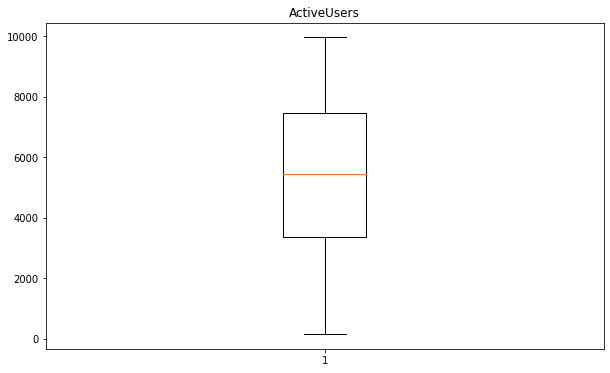

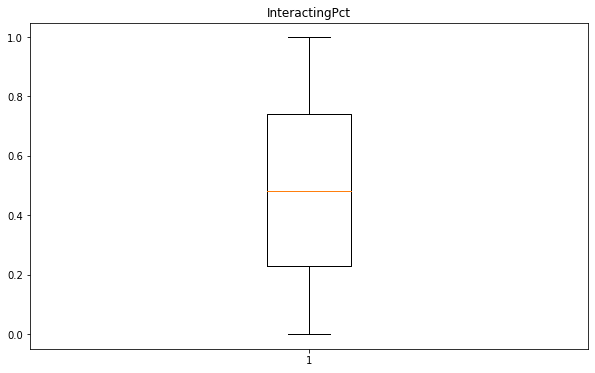

       ActiveUsers  InteractingPct        Ping
count   502.000000      502.000000  502.000000
mean   5485.830677        0.488613   50.545817
std    2548.935679        0.296000   14.797937
min     153.000000        0.000500   11.000000
25%    3357.500000        0.229300   40.000000
50%    5456.000000        0.482950   52.000000
75%    7461.500000        0.742475   60.000000
max    9953.000000        0.998600   90.000000


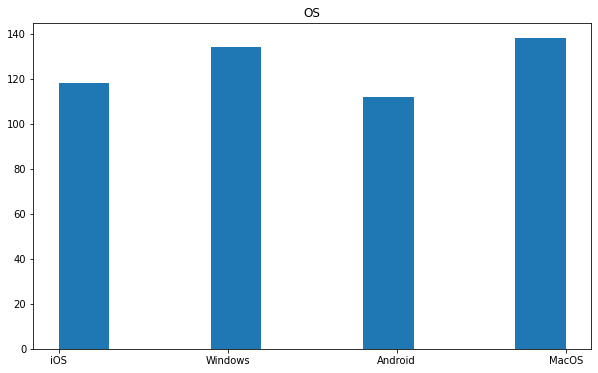

In [ ]:
# using visualizations to explore the data (outliers), for each column extra boxplot with appropriate range of values
# for each column extra boxplot with appropriate range of values in one figure
plt.figure(figsize=(10, 6))
plt.boxplot(data['ActiveUsers'])
plt.title('ActiveUsers')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(data['InteractingPct'])
plt.title('InteractingPct')
plt.show()

# analyze the data using the describe() method
print(data.describe())

# histogram for OS column
plt.figure(figsize=(10, 6))
plt.hist(data['OSType'])
plt.title('OS')
plt.show()

### Others

In [ ]:
# 1. option
mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType) + ActiveUsers*InteractingPct', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        11:23:19   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
# 2. option with dummy variables
# https://www.statsmodels.org/stable/example_formulas.html
# https://stackoverflow.com/questions/55738056/using-categorical-variables-in-statsmodels-ols-class
# 
# create dummy variables for OS column (one-hot encoding) and use it in the model instead of the original column OS column 
data1 = pd.get_dummies(data, columns=['OSType']).astype(float)

mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType_Android) + C(OSType_iOS) + C(OSType_Windows) + C(OSType_MacOS) + ActiveUsers*InteractingPct', data=data1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        11:23:19   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Je logické, že pro 4 kategorie nám stačí mít v modelu pouze 3, jelikož 4. kategorii jsme schopni dopočítat.

**Ping=11.2525+9.3104×MacOS+3.5404×Windows−5.8093×iOS+0.0053×ActiveUsers+32.8854×InteractingPct−0.0029×ActiveUsers×InteractingPct**



### Předpoklady lineární regrese a základní regresní diagnostiky

Diagnostika
- ověření základních předpokladů MNČ (kritika metody):
ověření stejného rozptylu, ověření autokorelace (Durbin-Watson), ověření normality (Omnibus; Prob(Omnibus); Jarque-Bera (JB); Prob(JB))
- ověření vhodnosti modelu pro daná data (kritika modelu):
ověření, zda v datech je nějaká závislost, ověření kvality modelu
- vhodnosti dat pro navržený regresní model (kritika dat):
zjištění vlivných bodů, vlivné body v nezávisle proměnných, vlivné body v závisle proměnných 

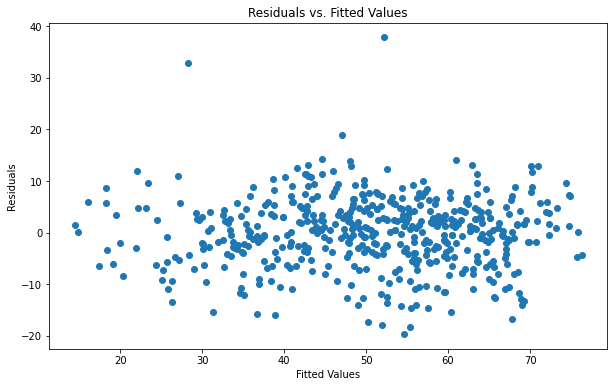

<Figure size 720x432 with 0 Axes>

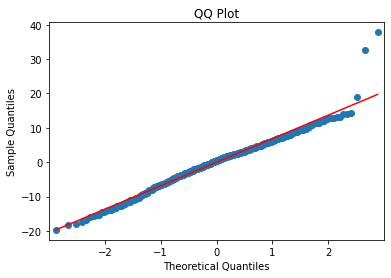

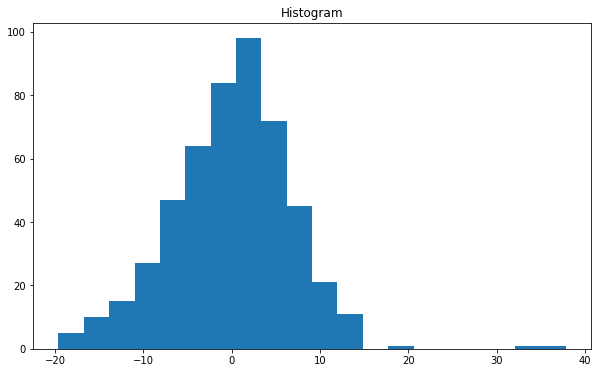

In [ ]:
# visualize the residuals of the model
plt.figure(figsize=(10, 6))
plt.scatter(res.fittedvalues, res.resid)
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# using QQ plot to check the normality of the residuals
plt.figure(figsize=(10, 6))
sm.qqplot(res.resid, line='s')
plt.title('QQ Plot')
plt.show()

# using histogram to check the normality of the residuals
plt.figure(figsize=(10, 6))
plt.hist(res.resid, bins=20)
plt.title('Histogram')
plt.show()


255
OSType            Windows
ActiveUsers          5513
InteractingPct     0.4912
Ping                   90
Name: 255, dtype: object

476
OSType             MacOS
ActiveUsers          153
InteractingPct    0.2111
Ping                  61
Name: 476, dtype: object

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     340.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          8.85e-172
Time:                        11:23:19   Log-Likelihood:                -1643.9
No. Observations:                 500   AIC:                             3302.
Df Residuals:                     493   BIC:                             3331.
Df Model:                           6                                         
Covariance Type:         

<Figure size 720x432 with 0 Axes>

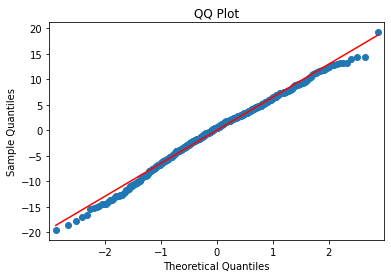

In [ ]:
# indentify outliers
outliers = res.resid[res.resid > 20]
for i in outliers.index:
    print(i)
    print(str(data.iloc[i]) + "\n")

# delete outliers
data = data.drop(outliers.index)
data = data.reset_index(drop=True)

mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType) + ActiveUsers*InteractingPct', data=data)
res = mod.fit()
print(res.summary())

plt.figure(figsize=(10, 6))
sm.qqplot(res.resid, line='s')
plt.title('QQ Plot')
plt.show()

### Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [ ]:
data.columns

Index(['OSType', 'ActiveUsers', 'InteractingPct', 'Ping'], dtype='object')

In [ ]:
# Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.
# calculate mean values of numeric variables in data
numeric_variables = data.select_dtypes(include=[np.number])
# calculate mean values
mean_numeric_values = numeric_variables.mean().drop('Ping')
# add OSType column
mean_numeric_values['OSType'] = 'Windows'
input_values = pd.DataFrame([mean_numeric_values])
# provide model with input values
# predict the response
predicted_values = res.predict(input_values)
print(f'Predicted ping: {predicted_values}')
print(mean_numeric_values)

# select all records where OSType is Windows
data_windows = data[data['OSType'] == 'Windows']
predicted_values = res.get_prediction(data_windows)
pred = predicted_values.summary_frame(alpha=0.05) #95% intervaly
X_new = pd.DataFrame({'x':np.arange(min(data["Ping"]),max(data["Ping"]),0.5)})
# # plot prediction interval 
# plt.plot(np.array(X_new['x']),np.array(pred['mean']))
# plt.grid(True)
# plt.fill_between(np.array(X_new['x']), np.array(pred['mean_ci_lower']) , np.array(pred['mean_ci_upper']), color='b', alpha=0.15)
# plt.fill_between(np.array(X_new['x']), np.array(pred['obs_ci_lower']) , np.array(pred['obs_ci_upper']), color='g', alpha=0.15)
# plt.xlabel('x')
# plt.ylabel('y - response')
# plt.show()
pred['mean']

Predicted ping: 0    51.815227
dtype: float64
ActiveUsers       5496.442
InteractingPct    0.489163
OSType             Windows
dtype: object


0      63.059135
1      54.005923
2      50.410972
3      68.705706
4      39.901052
         ...    
128    58.432435
129    57.698902
130    56.355355
131    32.795570
132    40.270215
Name: mean, Length: 133, dtype: float64